# Image Search Based on a Natural Language Query Using CLIP Model

In this notebook, we implement a simople image search solution based on a natural language query using the CLIP model [1]. We use CLIP to pre-calculate embeddigns for images in a collection. For a given query, we calculate its embedding using CLIP and then search for the nearest neighbors in the collection of image embeddigns. 

The implementation is based on [2].

### References
  1. https://openai.com/blog/clip/#rf33
  2. https://github.com/haltakov/natural-language-image-search
  
### Data
We use a small image collection available in the `tensorhouse-data` repository (`tensor-house-data/search/unspash-small`).

## Load the CLIP Model

In [4]:
import clip
import torch
import math
import numpy as np
import pandas as pd
import streamlit as st

from PIL import Image
import shutil
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from mpl_toolkits.axes_grid1 import ImageGrid

## Load CLIP Model

In [5]:
#
# Load the open CLIP model
#
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Process Input Images and Save Features

In [11]:
import boto3
from PIL import Image
from io import BytesIO
from IPython.display import display

# Collect AWS secrets
bucket_name = st.secrets.aws_credentials.bucket_name
service_name = st.secrets.aws_credentials.service_name
aws_access_key_id = st.secrets.aws_credentials.aws_access_key_id
aws_secret_access_key = st.secrets.aws_credentials.aws_secret_access_key
region_name = st.secrets.aws_credentials.region_name

# S3 client setup
s3_client = boto3.client(
    service_name="s3",
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region_name
)

def display_images_from_s3(image_ids, s3_client):
    for image_id in image_ids:
        # Download image from S3 directly into memory
        image_data = s3_client.get_object(Bucket=bucket_name, Key=image_id)['Body'].read()
        
        # Display the image using PIL
        image = Image.open(BytesIO(image_data))
        
        # Display the image in the console
        display(image)

# List all objects in the specified folder
folder_path = 'Wardrobe/'
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)

# Extract object keys from the response
all_image_ids = [obj['Key'] for obj in response.get('Contents', [])]

# Display images directly from S3
# display_images_from_s3(all_image_ids, s3_client)


In [13]:
def display_images_from_s3(image_ids, s3_client):
    rows, columns = 4, 4
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(rows, columns),  
                     axes_pad=0.1,  
                     )
    
    for ax, image_id in zip(grid, image_ids[:rows*columns]):
        # Download image from S3 directly into memory
        image_data = s3_client.get_object(Bucket=bucket_name, Key=image_id)['Body'].read()

        # Display the image using PIL
        image = Image.open(BytesIO(image_data))
        ax.imshow(image)
        ax.axis('off')

    plt.show()

# List all objects in the specified folder
folder_path = 'Wardrobe/'
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)

# Extract object keys from the response
all_image_ids = [obj['Key'] for obj in response.get('Contents', [])]

# Display images directly from S3
# display_images_from_s3(all_image_ids, s3_client)
def display_images_from_s3(image_ids, s3_client):
    rows, columns = 4, 4
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(rows, columns),  
                     axes_pad=0.1,  
                     )
    
    for ax, image_id in zip(grid, image_ids[:rows*columns]):
        # Download image from S3 directly into memory
        image_data = s3_client.get_object(Bucket=bucket_name, Key=image_id)['Body'].read()

        # Display the image using PIL
        image = Image.open(BytesIO(image_data))
        ax.imshow(image)
        ax.axis('off')

    plt.show()

# List all objects in the specified folder
folder_path = 'Wardrobe/'
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)

# Extract object keys from the response
all_image_ids = [obj['Key'] for obj in response.get('Contents', [])]

# Display images directly from S3
# display_images_from_s3(all_image_ids, s3_client)

Images found: 34


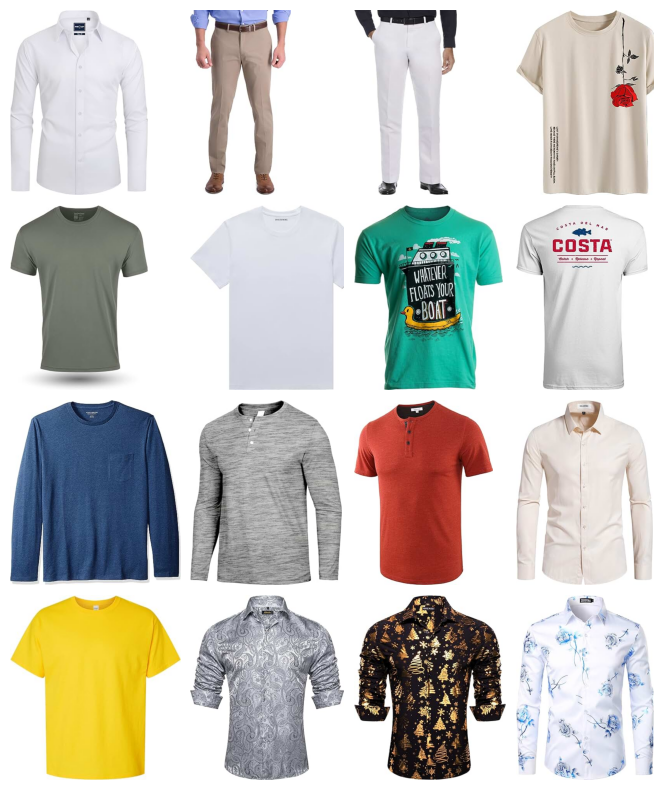

In [14]:
from pathlib import Path

# Set the path to the images
images_path = Path('Data')

# List all JPGs in the folder
images_files = list(images_path.glob('*.jpg'))

# Print some statistics
print(f'Images found: {len(images_files)}')

# Display images
rows, columns = (4, 4)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(rows, columns),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, images_files[:rows*columns]):
    ax.imshow(Image.open(im))
    ax.axis('off')
plt.show()

In [16]:
def s3_object_exists(bucket_name, key):
    try:
        s3_client.head_object(Bucket=bucket_name, Key=key)
        return True
    except Exception as e:
        return False

# Path where the feature vectors will be stored
features_path = "features"

# Function that computes the feature vectors for a batch of images
def compute_clip_features(images_batch):
    # Load all the images from S3
    images = [Image.open(BytesIO(s3_client.get_object(Bucket=bucket_name, Key=image_key)['Body'].read())) for image_key in images_batch]

    # Preprocess all images
    images_preprocessed = torch.stack([preprocess(image) for image in images]).to(device)

    with torch.no_grad():
        # Encode the images batch to compute the feature vectors and normalize them
        images_features = model.encode_image(images_preprocessed)
        images_features /= images_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return images_features.cpu().numpy()

# Define the batch size
batch_size = 16

# Compute how many batches are needed
batches = math.ceil(len(all_image_ids) / batch_size)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = f"{features_path}/{i:010d}.csv"
    batch_features_path = f"{features_path}/{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not s3_object_exists(bucket_name, batch_features_path):
        try:
            # Select the images for the current batch
            batch_files = all_image_ids[i*batch_size : (i+1)*batch_size]

            # Compute the features
            batch_features = compute_clip_features(batch_files)

            # Save the features to S3
            with BytesIO() as features_buffer:
                np.save(features_buffer, batch_features)
                features_buffer.seek(0)
                s3_client.upload_fileobj(features_buffer, bucket_name, batch_features_path)

            # Save the image IDs to a CSV file
            image_ids = [image_file.split("/")[-1].split(".")[0] for image_file in batch_files]
            image_ids_data = pd.DataFrame(image_ids, columns=['image_id'])
            with BytesIO() as ids_buffer:
                image_ids_data.to_csv(ids_buffer, index=False)
                ids_buffer.seek(0)
                s3_client.upload_fileobj(ids_buffer, bucket_name, batch_ids_path)

        except Exception as e:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i} {e}')


Processing batch 1/3
Processing batch 2/3
Processing batch 3/3


In [18]:

# S3 path where numpy files are stored
features_path_s3 = "features"

# Load all numpy files from S3
features_list = []

response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=features_path_s3)
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.npy'):
        features_data = s3_client.get_object(Bucket=bucket_name, Key=key)['Body'].read()
        features = np.load(BytesIO(features_data))
        features_list.append(features)

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
with BytesIO() as features_buffer:
    np.save(features_buffer, features)
    features_buffer.seek(0)
    s3_client.upload_fileobj(features_buffer, bucket_name, features_path_s3 + "features.npy")

# Load all the image IDs from S3
image_ids_list = []

response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=features_path_s3)
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.csv'):
        image_ids_data = s3_client.get_object(Bucket=bucket_name, Key=key)['Body'].read()
        image_ids = pd.read_csv(BytesIO(image_ids_data))
        image_ids_list.append(image_ids)

image_ids = pd.concat(image_ids_list)
with BytesIO() as ids_buffer:
    image_ids.to_csv(ids_buffer, index=False)
    ids_buffer.seek(0)
    s3_client.upload_fileobj(ids_buffer, bucket_name, features_path_s3 + "image_ids.csv")


## Load Features

In [20]:
# S3 path where CSV and numpy files are stored
features_path_s3 = "features"

# Load the image IDs from S3
image_ids_data = s3_client.get_object(Bucket=bucket_name, Key=features_path_s3 + 'image_ids.csv')['Body'].read()
image_ids = pd.read_csv(BytesIO(image_ids_data))
image_ids = list(image_ids['image_id'])

# Load the features vectors from S3
features_data = s3_client.get_object(Bucket=bucket_name, Key=features_path_s3 + 'features.npy')['Body'].read()
image_features = np.load(BytesIO(features_data))

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
    image_features = torch.from_numpy(image_features).float().to(device)
else:
    image_features = torch.from_numpy(image_features).to(device)

# Print some statistics
print(f"Images loaded: {len(image_ids)}")


Images loaded: 34


## Search Images Based on a Text Query 

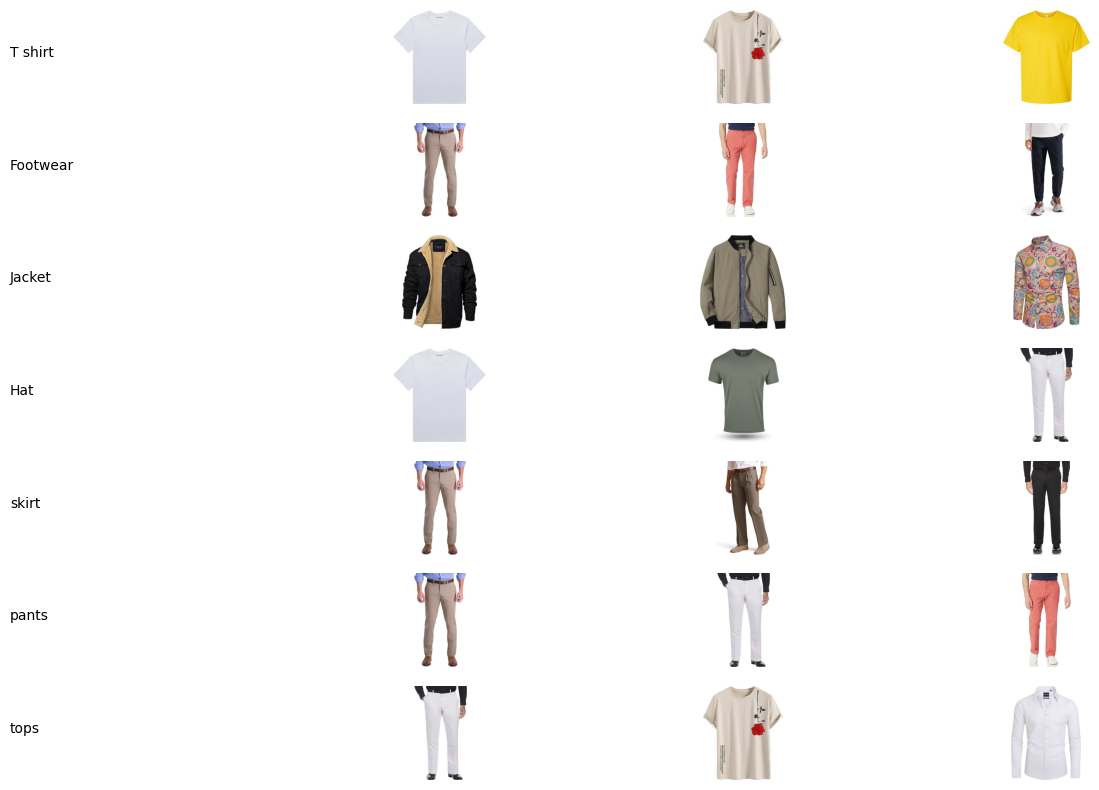

In [8]:
def encode_search_query(search_query):
    with torch.no_grad():
        # Encode and normalize the search query using CLIP
        text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
        text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

    # Retrieve the feature vector
    return text_encoded

def find_best_matches(text_features, image_features, image_ids, results_count=3):
  # Compute the similarity between the search query and each image using the Cosine similarity
  similarities = (image_features @ text_features.T).squeeze(1)

  # Sort the images by their similarity score
  best_image_idx = (-similarities).argsort()

  # Return the image IDs of the best matches
  return [image_ids[i] for i in best_image_idx[:results_count]]

def search(search_query, image_features, image_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  return find_best_matches(text_features, image_features, image_ids, results_count)

#
# Search for images and visualize the results
#
search_queries = ['T shirt', 
                  'Footwear', 
                  'Jacket', 
                  'Hat',
                  'skirt',
                  'pants',
                  'tops']
n_results_per_query = 3
 
fig, ax = plt.subplots(len(search_queries), n_results_per_query + 1, figsize=(15, 10))    
for i, search_query in enumerate(search_queries):
    result_image_ids = search(search_query, image_features, image_ids, n_results_per_query)
    
    ax[i, 0].text(0.0, 0.5, search_query)
    ax[i, 0].axis('off')
    for j, image_id in enumerate(result_image_ids):
        image = Image.open(f'{images_path}/{image_id}.jpg')
        ax[i, j+1].imshow(image)
        ax[i, j+1].axis('off')